In [1]:
#import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import os
import sys
import matplotlib.pyplot as plt

In [2]:
deeplabv3plus_dir="./src"
sys.path.append(deeplabv3plus_dir)

In [3]:
gpu_options = tf.compat.v1.GPUOptions(visible_device_list="0", allow_growth=True)
config = tf.compat.v1.ConfigProto(gpu_options = gpu_options)
tf.compat.v1.enable_eager_execution(config=config)

In [4]:
from model import deeplab_v3plus_transfer
#from image_utils import make_x_from_image_paths,make_y_from_image_paths,convert_y_to_image_array
from data_gen import DataGenerator

In [5]:
import importlib
importlib.reload(sys.modules['data_gen'])

<module 'data_gen' from './src/data_gen.py'>

In [6]:
out_dir = "unfreeze_xception_transfer"
os.makedirs(out_dir, exist_ok=True)

In [7]:
n_categories = 21
image_size = (512,512)

In [8]:
seg_img_dir = "../pascal_voc_2012_datasets/VOCdevkit/VOC2012/SegmentationClass"
img_dir = "../pascal_voc_2012_datasets/VOCdevkit/VOC2012/JPEGImages"
train_set_path = "../pascal_voc_2012_datasets/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt"
valid_set_path = "../pascal_voc_2012_datasets/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt"

with open(train_set_path) as f:
    train_img_names = f.read().split("\n")[:-1]
with open(valid_set_path) as f:
    valid_img_names = f.read().split("\n")[:-1]

img_paths = [os.path.join(img_dir,train_img_names[i]) + ".jpg" for i in range(len(train_img_names))]
seg_img_paths = [os.path.join(seg_img_dir,train_img_names[i]) + ".png" for i in range(len(train_img_names))]

valid_x_paths = [os.path.join(img_dir,valid_img_names[i]) + ".jpg" for i in range(len(valid_img_names))]
valid_y_paths = [os.path.join(seg_img_dir,valid_img_names[i]) + ".png" for i in range(len(valid_img_names))]

In [9]:
batch_size=16
n_epochs=300

In [10]:
train_data_gen = DataGenerator(n_categories, image_size, batch_size, img_paths    , seg_img_paths, augmentation=True )
valid_data_gen = DataGenerator(n_categories, image_size, batch_size, valid_x_paths, valid_y_paths, augmentation=False)

In [11]:
model = keras.models.load_model('./saved_model_transfer/final_epoch.h5')

W1128 12:58:38.140564 140735578197200 deprecation.py:323] From /home/taniguchi-j/anaconda3/envs/ppc/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
model.trainable=True

In [15]:
loss_function = tf.keras.losses.categorical_crossentropy
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt, loss=loss_function, metrics=["accuracy"])

In [16]:
model.summary()

Model: "xception_deeplab-v3plus"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 255, 255, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 255, 255, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________

In [17]:
filepath = os.path.join(out_dir,'{epoch:06d}.h5')
cp_cb = keras.callbacks.ModelCheckpoint(filepath, 
                                        monitor='val_loss', 
                                        verbose=0, 
                                        save_best_only=True, 
                                        save_weights_only=False, 
                                        mode='auto')

In [18]:
#hist = model.fit_generator(data_gen, validation_data=(valid_x, valid_y), epochs=par.n_epochs, steps_per_epoch=par.n_batch, callbacks=[cp_cb])
hist = model.fit_generator(train_data_gen,
                           epochs=n_epochs,
                           steps_per_epoch=len(train_data_gen),
                           validation_data=valid_data_gen,
                           validation_steps=len(valid_data_gen),
                           shuffle = True,
                           workers=8,
                           use_multiprocessing=True,
                           callbacks=[cp_cb])
#hist = model.fit_generator(data_gen, epochs=par.n_epochs, steps_per_epoch=par.n_batch, workers=8, use_multiprocessing=True)

Epoch 1/300
92/92 [==============================] - 245s 3s/step - loss: 0.7860 - acc: 0.8021 - val_loss: 1.2411 - val_acc: 0.7771
Epoch 2/300
92/92 [==============================] - 171s 2s/step - loss: 0.5721 - acc: 0.8279 - val_loss: 1.0285 - val_acc: 0.7848
Epoch 3/300
92/92 [==============================] - 175s 2s/step - loss: 0.4840 - acc: 0.8440 - val_loss: 1.0482 - val_acc: 0.7465
Epoch 4/300
92/92 [==============================] - 178s 2s/step - loss: 0.3557 - acc: 0.8813 - val_loss: 0.7301 - val_acc: 0.7993
Epoch 5/300
92/92 [==============================] - 166s 2s/step - loss: 0.3276 - acc: 0.8865 - val_loss: 0.6044 - val_acc: 0.8328
Epoch 6/300
92/92 [==============================] - 175s 2s/step - loss: 0.2642 - acc: 0.9089 - val_loss: 0.5637 - val_acc: 0.8475
Epoch 7/300
92/92 [==============================] - 202s 2s/step - loss: 0.2153 - acc: 0.9236 - val_loss: 0.4997 - val_acc: 0.8610
Epoch 8/300
92/92 [==============================] - 173s 2s/step - loss: 0.

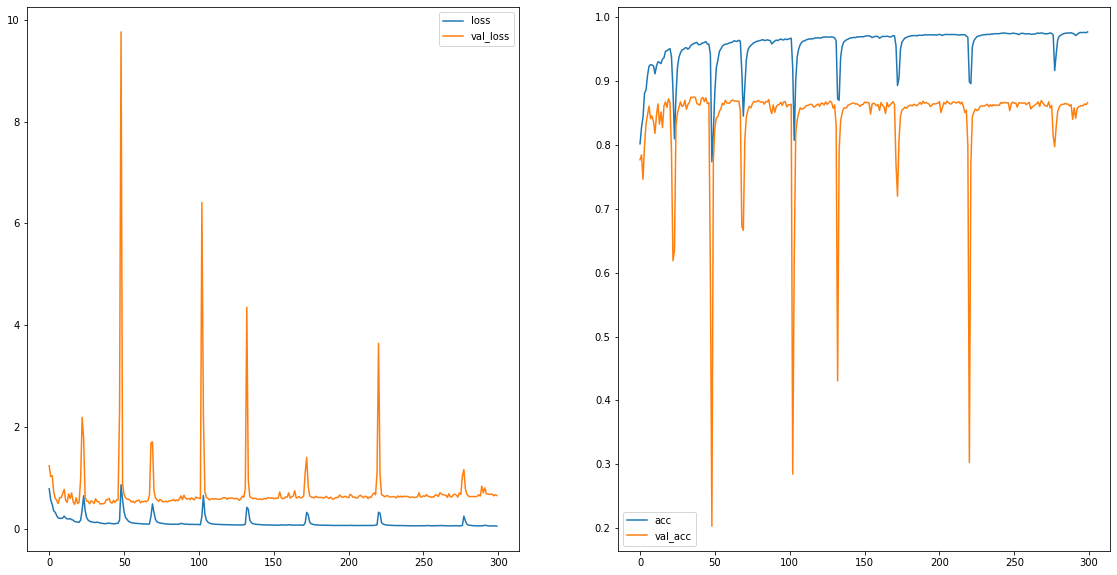

In [19]:
plt.figure(figsize=(30,10))

plt.subplot(1,3,1)
plt.plot(hist.history["loss"], label="loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.legend()

plt.subplot(1,3,2)
plt.plot(hist.history["acc"], label="acc")
plt.plot(hist.history["val_acc"], label="val_acc")
plt.legend()
plt.savefig(os.path.join(out_dir,'losscurve.png'))

In [20]:
model.save(os.path.join(out_dir,'final_epoch.h5'))

In [21]:
import numpy as np
for key in sorted(hist.history.keys()):
    np.savetxt(os.path.join(out_dir,key+'.txt'),np.array(hist.history[key]))
